## Import data and set up parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from utils import *
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
torch.use_deterministic_algorithms(True)
from easydict import EasyDict as ed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence
from captum.attr import FeaturePermutation
if is_notebook():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

clr = sns.color_palette("deep")

np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

split_by = 'material' # 'random' or 'material'

validation = True
physics_informed = False
bayes_opt = True

data_path = '../data/SNL_MSU_DOE_fatigue.xlsx'
ckp_path = '../output/fatigue.pt'
skopt_path = '../output/skopt.pt'

n_calls = 200
layers = [16, 64, 128, 256, 256, 128, 64, 16]

# static_params = {'patience': 500, 'epoch': 2000, 'weight_decay': 0.0}
# chosen_params = {'lr': 0.0062111007822585485, 'batch_size': 128}
# SPACE = [
#     Real(1e-4, 0.05, 'log-uniform', name='lr'),
#     Categorical([32, 64, 128, 256, 512, 1024, 2048], name='batch_size'),
# ]

static_params = {'patience': 1000, 'epoch': 4000}
chosen_params = {'lr': 0.0034560325081541875, 'weight_decay': 0.0019904362054363267, 'batch_size': 1024} # for random split
# chosen_params = {'lr': 0.01, 'weight_decay': 0.005, 'batch_size': 1024}
# chosen_params = {'lr': 0.0008576159573733293, 'weight_decay': 0.005, 'batch_size': 32}
SPACE = [
    Real(1e-3, 0.05, 'log-uniform', name='lr'),
    Real(1e-5, 0.05, 'log-uniform', name='weight_decay'),
    Categorical([32, 64, 128, 256, 512, 1024, 2048, 4096], name='batch_size'),
]

Using cpu device


## Set datasets

In [2]:
data = pd.read_excel(data_path, engine='openpyxl')

name_mapping = {
    'Material': 'Material',
    'Resin Type': 'Resin Type',
    'Vf, %': 'Fibre Volumn Fraction',
    '%, 0 Deg': 'Percentage of Fibre in 0-deg Direction',
    '%, 45 Deg': 'Percentage of Fibre in 45-deg Direction',
    '%, 90 Deg': 'Percentage of Fibre in 90-deg Direction',
    'other %': 'Percentage of Fibre in Other Direction',
    'Thickness, mm': 'Thickness',
    'Max. Stress, MPa': 'Maximum Stress',
    'Min. Stress, MPa': 'Minimum Stress',
    'R-value': 'Minimum/Maximum Stress',
    'Freq., Hz': 'Frequency',
    'E, GPa': 'Initial Elastic Modulus',
    'Max. % Strain': 'Maximum Strain',
    'Min. % Strain': 'Minimum Strain',
    'Cycles': 'Cycles to Failure',
    'Moisture Gain, %': 'Moisture Gain',
    'Testing Temperature, OC': 'Temperature',
    'Width, mm': 'Width',
    'Static Max. Stress, MPa': 'Static Maximum Tensile Stress',
    'Static Min. Stress, MPa': 'Static Maximum Compressive Stress',
    'Static E, GPa': 'Static Elastic Modulus',
    'Static Max. % Strain': 'Static Maximum Tensile Strain',
    'Static Min. % Strain': 'Static Maximum Compressive Strain',
    'Absolute Maximum Stress': 'Absolute Maximum Stress',
    'Absolute Peak-to-peak Stress': 'Absolute Peak-to-peak Stress',
    'Relative Maximum Stress': 'Relative Maximum Stress',
    'Relative Peak-to-peak Stress': 'Relative Peak-to-peak Stress'
}

data = replace_column_name(data, name_mapping)

feature_names = ['Percentage of Fibre in 0-deg Direction',
                 'Percentage of Fibre in 45-deg Direction',
                 'Percentage of Fibre in 90-deg Direction',
                 'Percentage of Fibre in Other Direction',
                 'Absolute Maximum Stress',
                 'Absolute Peak-to-peak Stress',
                 'Frequency',
                 'Fibre Volumn Fraction',
                 'Relative Maximum Stress',
                 'Relative Peak-to-peak Stress',
                 'Thickness',
                 'Static Maximum Tensile Stress',
                 'Static Maximum Tensile Strain',
                 'Static Elastic Modulus']

label_name = ['Cycles to Failure']

tmp_data = data[feature_names+label_name+['Material', 'Lay-up']].copy().dropna(axis=0)

material_names = tmp_data['Material'].copy()
lay_up = tmp_data['Lay-up'].copy()
mat_lay = np.array([x+y for x,y in zip(material_names, lay_up)], dtype=str)
mat_lay_set = list(set(mat_lay))

data = data[feature_names+label_name].dropna(axis=0)
feature_data = data[feature_names]
label_data = np.log10(data[label_name])

X = torch.tensor(feature_data.values, dtype=torch.float32).to(device)
y = torch.tensor(label_data.values, dtype=torch.float32).to(device)
dataset = Data.TensorDataset(X, y)

if validation:
    train_val_test = np.array([0.6, 0.2, 0.2])
    if split_by == 'random':
        train_size = np.floor(len(label_data) * train_val_test[0]).astype(int)
        val_size = np.floor(len(label_data) * train_val_test[1]).astype(int)
        test_size = len(label_data) - train_size - val_size
        train_dataset, val_dataset, test_dataset = Data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(0))
    elif split_by == 'material':
        train_dataset, val_dataset, test_dataset = split_by_material(dataset, mat_lay, mat_lay_set, train_val_test, validation)
    else:
        raise Exception('Split type not implemented')

    print('Dataset size:', len(train_dataset), len(val_dataset), len(test_dataset))
else:
    train_test = np.array([0.8, 0.2])
    if split_by == 'random':
        train_size = np.floor(len(label_data) * train_test[0]).astype(int)
        test_size = len(label_data) - train_size
        train_dataset, test_dataset = Data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))
    elif split_by == 'material':
        train_dataset, test_dataset = split_by_material(dataset, mat_lay, mat_lay_set, train_test, validation)
    else:
        raise Exception('Split type not implemented')
    print('Dataset size:', len(train_dataset), len(test_dataset))
   
scaler = StandardScaler() 
# scaler = MinMaxScaler()
scaler.fit(train_dataset.dataset.tensors[0].cpu().numpy()[train_dataset.indices, :])
# torch.data.Dataset.Subset share the same memory, so only transform once.
transformed = scaler.transform(train_dataset.dataset.tensors[0].cpu().numpy())
train_dataset.dataset.tensors = (torch.tensor(transformed, dtype=torch.float32).to(device), train_dataset.dataset.tensors[1])
X = torch.tensor(scaler.transform(X.cpu().numpy()), dtype=torch.float32).to(device)

Dataset size: 2894 987 927


## Set NN structures and training functions

In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)


class NN(nn.Module):
    def __init__(self, layers=[128, 64, 32]):
        super(NN, self).__init__()
        num_inputs = len(feature_names)
        num_hiddens1 = layers[0]
        num_hiddens2 = layers[1]
        num_hiddens3 = layers[2]
        num_outputs = len(label_name)
        self.net = nn.Sequential()
        self.net.add_module('input', nn.Linear(num_inputs, layers[0]))
        self.net.add_module('ReLU', nn.ReLU())
        for idx in range(len(layers) - 1):
            self.net.add_module(str(idx), nn.Linear(layers[idx], layers[idx + 1]))
            self.net.add_module('ReLU' + str(idx), nn.ReLU())
        self.net.add_module('output', nn.Linear(layers[-1], num_outputs))

        self.net.apply(init_weights)

    def forward(self, x):
        x = self.net(x)
        return x


def train(model, train_loader, optimizer, loss_fn):
    model.train()
    avg_loss = 0
    for idx, (data, yhat) in enumerate(train_loader):
        optimizer.zero_grad()
        y = model(data)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * len(y)

    avg_loss /= len(train_loader.dataset)
    return avg_loss


def test(model, test_loader, loss_fn):
    model.eval()
    pred = []
    truth = []
    with torch.no_grad():
        # print(test_dataset)
        avg_loss = 0
        for idx, (data, yhat) in enumerate(test_loader):
            y = model(data)
            loss = loss_fn(yhat, y)
            avg_loss += loss.item() * len(y)
            pred += list(y.cpu().detach().numpy())
            truth += list(yhat.cpu().detach().numpy())
        avg_loss /= len(test_loader.dataset)
    return np.array(pred), np.array(truth), avg_loss

def test_tensor(test_tensor, test_label_tensor, model, loss_fn):
    model.eval()
    pred = []
    truth = []
    with torch.no_grad():
        y = model(test_tensor)
        loss = loss_fn(test_label_tensor, y)
    return y.cpu().detach().numpy(), test_label_tensor.cpu().detach().numpy(), loss.item()


class PI_MSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = self.mse(yhat, y) + self.eps + torch.sum(F.relu(-y)) / len(y) + torch.sum(F.relu(y - 5)) / len(y)
        return loss


if physics_informed:
    loss_fn = PI_MSELoss()
else:
    loss_fn = nn.MSELoss()

  0%|          | 0/200 [00:00<?, ?it/s]

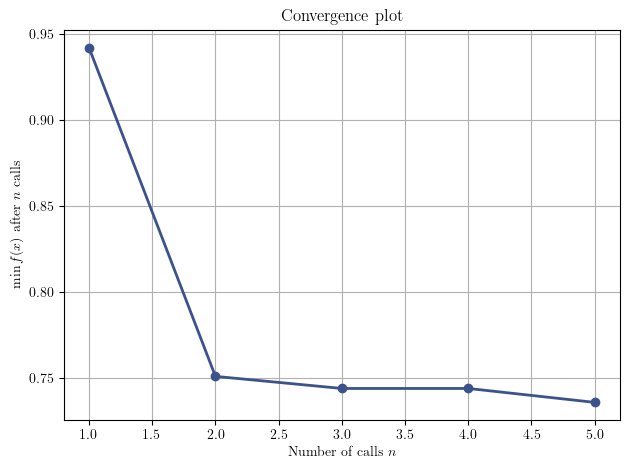

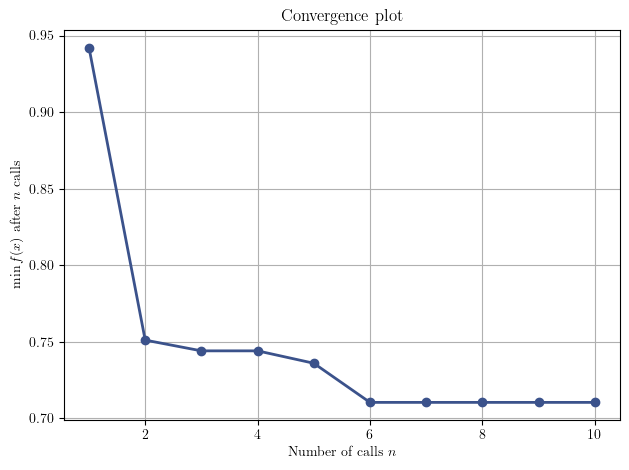

In [ ]:

def model_train(model = None, verbose = True, return_loss_list = True, verbose_per_epoch = 100, **params):
    # print(params)
    if model is None:
        model = NN(layers).to(device)
        
    train_loader = Data.DataLoader(train_dataset, batch_size=int(params['batch_size']), generator=torch.Generator().manual_seed(0))
    if validation:
        val_loader = Data.DataLoader(val_dataset, batch_size=len(val_dataset), generator=torch.Generator().manual_seed(0))
    test_loader = Data.DataLoader(test_dataset, batch_size=len(test_dataset), generator=torch.Generator().manual_seed(0))

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=params['lr'],
                                weight_decay=params['weight_decay'])
    
    train_ls = []
    val_ls = []
    stop_epoch = params['epoch']

    early_stopping = EarlyStopping(patience=params['patience'], verbose=False, path = ckp_path)

    for epoch in range(params['epoch']):
        train_loss = train(model, train_loader, optimizer, loss_fn)
        train_ls.append(train_loss)
        if validation:
            _, _, val_loss = test(model, val_loader, loss_fn)
            val_ls.append(val_loss)

        if verbose and ((epoch + 1) % verbose_per_epoch == 0 or epoch == 0):
            if validation:
                print(f'Epoch: {epoch + 1}/{stop_epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
            else:
                print(f'Epoch: {epoch + 1}/{stop_epoch}, Train loss: {train_loss:.4f}')

        if validation:
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                if verbose:
                    idx = val_ls.index(min(val_ls))
                    print(
                        f'Early stopping at epoch {epoch + 1}, Checkpoint at epoch {idx + 1}, Train loss: {train_ls[idx]:.4f}, Val loss: {val_ls[idx]:.4f}')
                stop_epoch = epoch + 1
                break
    if validation:
        idx = val_ls.index(min(val_ls))
        min_loss = val_ls[idx]
    else:
        min_loss = train_ls[-1]
    
    if return_loss_list:
        return min_loss, train_ls, val_ls
    else:
        return min_loss


if bayes_opt:
    bar = tqdm(total=n_calls)
    
    @skopt.utils.use_named_args(SPACE)
    def objective(**params):
        res = model_train(verbose=False, return_loss_list=False, **{**params, **static_params})

        return res

    postfix = {'Current loss': 1e8, 'Minimum': 1e8, 'Params': list(chosen_params.values()), 'Minimum at call': 0}
    def callback(result):
        postfix['Current loss'] = result.func_vals[-1]

        if result.fun < postfix['Minimum']:
            postfix['Minimum'] = result.fun
            postfix['Params'] = result.x
            postfix['Minimum at call'] = len(result.func_vals)
        skopt.dump(result,skopt_path)

        if len(result.func_vals) % 5 == 0:
            plt.figure()
            ax = plt.subplot(111)
            ax = plot_convergence(result, ax)
            plt.savefig('../output/skopt_convergence.svg')
            if is_notebook():
                plt.show()
            plt.close()

        bar.set_postfix(**postfix)
        bar.update(1)

    result = gp_minimize(objective, SPACE, n_calls=n_calls, random_state=0, x0=list(chosen_params.values()), callback=callback)
    print(result.func_vals.min())


## Training

In [ ]:
model = NN(layers).to(device)

if bayes_opt:
    params = {}
    for key,value in zip(chosen_params.keys(), result.x):
        params[key] = value

    print(params)
else:
    params = chosen_params

min_loss,train_ls,val_ls = model_train(model, verbose_per_epoch=100, **{**params, **static_params})

if validation:
    model.load_state_dict(torch.load(ckp_path))

print('Minimum loss:', min_loss)

In [ ]:
plt.figure()
plt.rcParams['font.size'] = 20
ax = plt.subplot(111)
ax.plot(np.arange(len(train_ls)), train_ls, label='Train loss', linewidth=2, color=clr[0])
if validation:
    ax.plot(np.arange(len(val_ls)), val_ls, label='Validation loss', linewidth=2, color=clr[1])
# minposs = val_ls.index(min(val_ls))+1 
# ax.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax.legend()
ax.set_ylabel('MSE Loss')
ax.set_xlabel('Epoch')
plt.savefig('../output/loss_epoch.svg')
if is_notebook():
    plt.show()
plt.close()

## Plot results and compare NN with baseline models

In [ ]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

train_loader = Data.DataLoader(train_dataset, batch_size=int(params['batch_size']), generator=torch.Generator().manual_seed(0))
if validation:
    val_loader = Data.DataLoader(val_dataset, batch_size=len(val_dataset), generator=torch.Generator().manual_seed(0))
test_loader = Data.DataLoader(test_dataset, batch_size=len(test_dataset), generator=torch.Generator().manual_seed(0))

prediction, ground_truth, loss = test(model, train_loader, loss_fn)
r2 = r2_score(ground_truth, prediction)
print(f'Train MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

if validation:
    prediction, ground_truth, loss = test(model, val_loader, loss_fn)
    r2 = r2_score(ground_truth, prediction)
    print(f'Validation MSE Loss: {loss:.4f}, R2: {r2:.4f}')
    plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[2], label=f'Val dataset ($R^2$={r2:.3f})',
                    linewidth=0.4, edgecolors='k')

prediction, ground_truth, loss = test(model, test_loader, loss_fn)
r2 = r2_score(ground_truth, prediction)
print(f'Test MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

def set_truth_pred(ax):
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.plot(np.linspace(0, 10 ** 8, 100), np.linspace(0, 10 ** 8, 100), '--', c='grey', alpha=.2, )
    ax.set_aspect('equal', 'box')
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[0.1 * x for x in range(10)], numticks=20)

    # ax.set(xlim=[10, 10 ** 6], ylim=[10, 10 ** 6])
    ax.xaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # data_range = [
    #     np.floor(np.min([np.min(ground_truth), np.min(prediction)])),
    #     np.ceil(np.max([np.max(ground_truth), np.max(prediction)]))
    # ]
    
set_truth_pred(ax)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
train_x_rf = feature_data.values[np.array(train_dataset.indices), :]
train_y_rf = label_data.values[np.array(train_dataset.indices), :]

test_x_rf = feature_data.values[np.array(test_dataset.indices), :]
test_y_rf = label_data.values[np.array(test_dataset.indices), :]

rf.fit(train_x_rf, train_y_rf)

plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

pred_y = rf.predict(train_x_rf)
r2 = r2_score(train_y_rf, pred_y)
loss = np.mean((train_y_rf[:, 0] - pred_y) ** 2)
print(f'Train MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** train_y_rf, 10 ** pred_y, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

pred_y = rf.predict(test_x_rf)
r2 = r2_score(test_y_rf, pred_y)
loss = np.mean((test_y_rf[:, 0] - pred_y) ** 2)
print(f'Test MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** test_y_rf, 10 ** pred_y, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')
    
set_truth_pred(ax)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/rf_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

In [ ]:
from sklearn import svm

sv = svm.SVR()
sv.fit(train_x_rf, train_y_rf)

plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

pred_y = sv.predict(train_x_rf)
r2 = r2_score(train_y_rf, pred_y)
loss = np.mean((train_y_rf[:, 0] - pred_y) ** 2)
print(f'Train MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** train_y_rf, 10 ** pred_y, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

pred_y = sv.predict(test_x_rf)
r2 = r2_score(test_y_rf, pred_y)
loss = np.mean((test_y_rf[:, 0] - pred_y) ** 2)
print(f'Test MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** test_y_rf, 10 ** pred_y, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

set_truth_pred(ax)

plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/sv_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

## Permutation feature importance

In [ ]:

def forward_func(data):
    prediction, ground_truth, loss = test_tensor(data, y[test_dataset.indices,:], model, loss_fn)
    return loss

feature_perm = FeaturePermutation(forward_func)
attr = feature_perm.attribute(X[test_dataset.indices,:]).cpu().numpy()[0]

In [ ]:
clr = sns.color_palette("deep")

plt.figure(figsize=(7,4))
ax = plt.subplot(111)
plot_importance(ax, feature_names, attr, palette = clr)
plt.tight_layout()

plt.savefig('../output/feature_importance.svg')
# plt.close()
if is_notebook():
    plt.show()
plt.close()

## Partial dependence

In [ ]:

from utils import calculate_pdp
x_values_list = []
mean_pdp_list = []


for feature_idx in range(len(feature_names)):
    print('Calculate PDP: ',feature_names[feature_idx])
    
    pdp_list = []
    ci_left = []
    ci_right = []
    x_value, model_predictions = calculate_pdp(model,X[train_dataset.indices,:],feature_idx,grid_size=30)
    
    x_values_list.append(x_value)
    mean_pdp_list.append(model_predictions)
    
    
max_col = 4
if len(feature_names)>max_col:
    width = max_col
    if len(feature_names)%max_col == 0:
        height = len(feature_names)//max_col
    else:
        height = len(feature_names)//max_col + 1
    figsize = (14, 3*height)
else:
    figsize = (3*len(feature_names),2.5)
    width = len(feature_names)
    height = 1
print(figsize, width, height)

fig = plt.figure(figsize=figsize)

for idx,focus_feature in enumerate(feature_names):
    ax = plt.subplot(height,width,idx+1)
    # ax.plot(x_values_list[idx], mean_pdp_list[idx], color = clr_map[focus_feature], linewidth = 0.5)
    ax.plot(x_values_list[idx], 10**mean_pdp_list[idx], color = 'k', linewidth = 0.7)

    ax.set_title(focus_feature, {'fontsize': 12})
    ax.set_xlim([0,1])
    ax.set_yscale('log')
    ax.set_ylim([10**2, 10**7])
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[0.1 * x for x in range(10)], numticks=20)
    ax.xaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax2 = ax.twinx()

    chosen_data = X[test_dataset.indices,idx].cpu().detach().numpy()
    ax2.hist(chosen_data,bins=x_values_list[idx],density=True,color=[0,0,0],alpha = .2,rwidth=0.8)
    # sns.rugplot(data=chosen_data, height=0.05, ax=ax2, color='k')
    # ax2.set_ylim([0,1])
    ax2.set_xlim([np.min(x_values_list[idx]), np.max(x_values_list[idx])])
    ax2.set_yticks([])

ax = fig.add_subplot(111,frameon=False)
plt.tick_params(labelcolor='none', which = 'both', top=False,bottom=False, left = False, right=False)
plt.ylabel('Predicted fatigue life')
plt.xlabel('Value of predictors (standard scaled, $10\%$-$90\%$ percentile)')

plt.savefig('../output/partial_dependence.svg')
if is_notebook():
    plt.show()
plt.close()

In [ ]:
plt.figure()
plt.rcParams['font.size'] = 20
ax = plt.subplot(111)
ax.plot(np.arange(len(train_ls)), train_ls, label='Train loss', linewidth=2, color=clr[0])
if validation:
    ax.plot(np.arange(len(val_ls)), val_ls, label='Validation loss', linewidth=2, color=clr[1])
# minposs = val_ls.index(min(val_ls))+1 
# ax.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax.legend()
ax.set_ylabel('MSE Loss')
ax.set_xlabel('Epoch')
plt.savefig('../output/loss_epoch.svg')
if is_notebook():
    plt.show()
plt.close()

## Plot results and compare NN with baseline models

Train MSE Loss: 0.1286, R2: 0.9249
Validation MSE Loss: 0.2828, R2: 0.8330
Test MSE Loss: 0.3080, R2: 0.8165


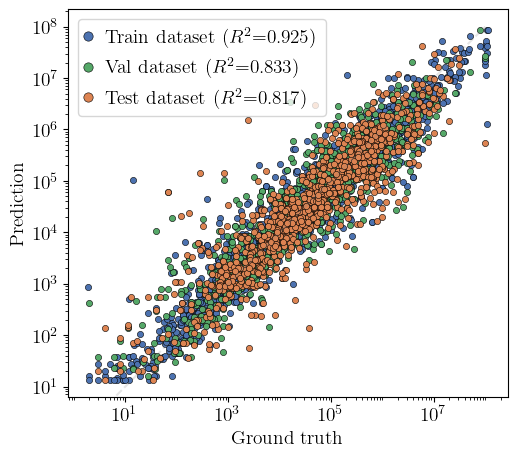

In [ ]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

train_loader = Data.DataLoader(train_dataset, batch_size=int(params['batch_size']))
if validation:
    val_loader = Data.DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = Data.DataLoader(test_dataset, batch_size=len(test_dataset))

prediction, ground_truth, loss = test(model, train_loader, loss_fn)
r2 = r2_score(ground_truth, prediction)
print(f'Train MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

if validation:
    prediction, ground_truth, loss = test(model, val_loader, loss_fn)
    r2 = r2_score(ground_truth, prediction)
    print(f'Validation MSE Loss: {loss:.4f}, R2: {r2:.4f}')
    plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[2], label=f'Val dataset ($R^2$={r2:.3f})',
                    linewidth=0.4, edgecolors='k')

prediction, ground_truth, loss = test(model, test_loader, loss_fn)
r2 = r2_score(ground_truth, prediction)
print(f'Test MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

def set_truth_pred(ax):
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.plot(np.linspace(0, 10 ** 8, 100), np.linspace(0, 10 ** 8, 100), '--', c='grey', alpha=.2, )
    ax.set_aspect('equal', 'box')
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[0.1 * x for x in range(10)], numticks=20)

    # ax.set(xlim=[10, 10 ** 6], ylim=[10, 10 ** 6])
    ax.xaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # data_range = [
    #     np.floor(np.min([np.min(ground_truth), np.min(prediction)])),
    #     np.ceil(np.max([np.max(ground_truth), np.max(prediction)]))
    # ]
    
set_truth_pred(ax)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

/home/xlluo/hdd/ML-fracture/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train MSE Loss: 0.0694, R2: 0.9595
Test MSE Loss: 0.3114, R2: 0.8145


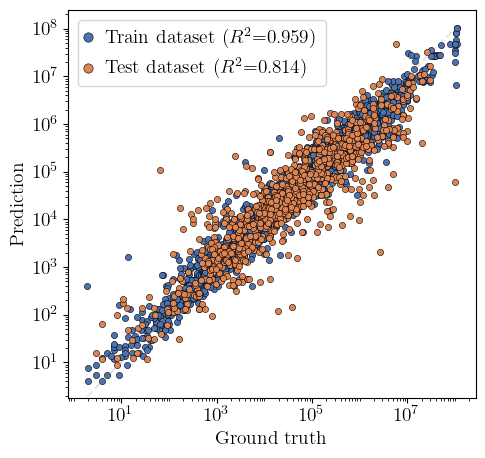

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
train_x_rf = feature_data.values[np.array(train_dataset.indices), :]
train_y_rf = label_data.values[np.array(train_dataset.indices), :]

test_x_rf = feature_data.values[np.array(test_dataset.indices), :]
test_y_rf = label_data.values[np.array(test_dataset.indices), :]

rf.fit(train_x_rf, train_y_rf)

plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

pred_y = rf.predict(train_x_rf)
r2 = r2_score(train_y_rf, pred_y)
loss = np.mean((train_y_rf[:, 0] - pred_y) ** 2)
print(f'Train MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** train_y_rf, 10 ** pred_y, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

pred_y = rf.predict(test_x_rf)
r2 = r2_score(test_y_rf, pred_y)
loss = np.mean((test_y_rf[:, 0] - pred_y) ** 2)
print(f'Test MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** test_y_rf, 10 ** pred_y, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')
    
set_truth_pred(ax)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/rf_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

/home/xlluo/hdd/ML-fracture/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train MSE Loss: 0.9655, R2: 0.4359
Test MSE Loss: 0.9330, R2: 0.4442


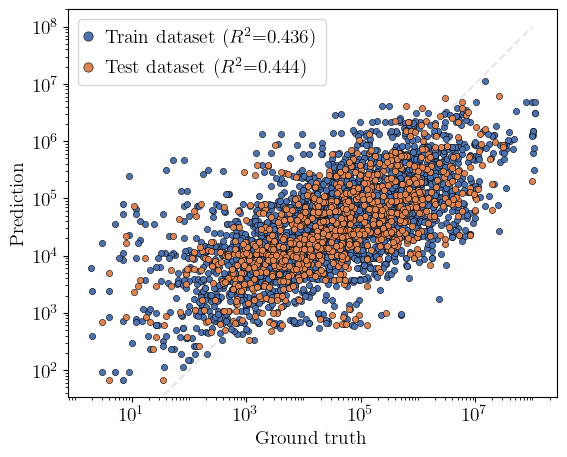

In [ ]:
from sklearn import svm

sv = svm.SVR()
sv.fit(train_x_rf, train_y_rf)

plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

pred_y = sv.predict(train_x_rf)
r2 = r2_score(train_y_rf, pred_y)
loss = np.mean((train_y_rf[:, 0] - pred_y) ** 2)
print(f'Train MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** train_y_rf, 10 ** pred_y, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

pred_y = sv.predict(test_x_rf)
r2 = r2_score(test_y_rf, pred_y)
loss = np.mean((test_y_rf[:, 0] - pred_y) ** 2)
print(f'Test MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** test_y_rf, 10 ** pred_y, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

set_truth_pred(ax)

plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/sv_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

## Permutation feature importance

In [ ]:

def forward_func(data):
    prediction, ground_truth, loss = test_tensor(data, y[test_dataset.indices,:], model, loss_fn)
    return loss

feature_perm = FeaturePermutation(forward_func)
attr = feature_perm.attribute(X[test_dataset.indices,:]).cpu().numpy()[0]
attr

array([-1.04401818, -0.57144591, -0.36010924, -0.11351579, -1.24397865,
       -0.80361989, -0.77529016, -0.71152571, -1.12119105, -0.62252608,
       -0.70949152, -0.68833897, -0.2605246 , -0.59576711])

/home/xlluo/hdd/ML-fracture/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


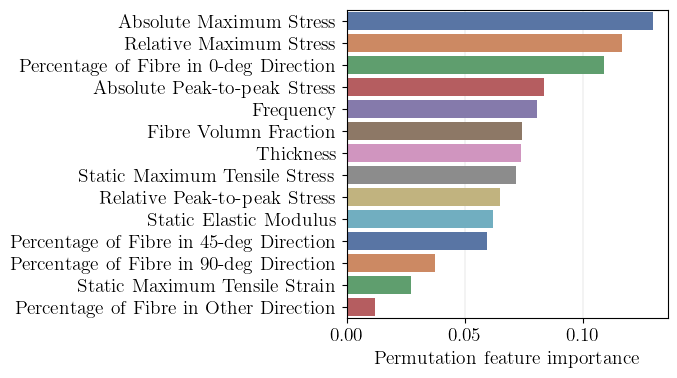

In [ ]:
clr = sns.color_palette("deep")

plt.figure(figsize=(7,4))
ax = plt.subplot(111)
plot_importance(ax, feature_names, attr, palette = clr)
plt.tight_layout()

plt.savefig('../output/feature_importance.svg')
# plt.close()
if is_notebook():
    plt.show()
plt.close()

## Partial dependence

Calculate PDP:  Percentage of Fibre in 0-deg Direction
Calculate PDP:  Percentage of Fibre in 45-deg Direction
Calculate PDP:  Percentage of Fibre in 90-deg Direction
Calculate PDP:  Percentage of Fibre in Other Direction
Calculate PDP:  Absolute Maximum Stress
Calculate PDP:  Absolute Peak-to-peak Stress
Calculate PDP:  Frequency
Calculate PDP:  Fibre Volumn Fraction
Calculate PDP:  Relative Maximum Stress
Calculate PDP:  Relative Peak-to-peak Stress
Calculate PDP:  Thickness
Calculate PDP:  Static Maximum Tensile Stress
Calculate PDP:  Static Maximum Tensile Strain
Calculate PDP:  Static Elastic Modulus
(14, 12) 4 4


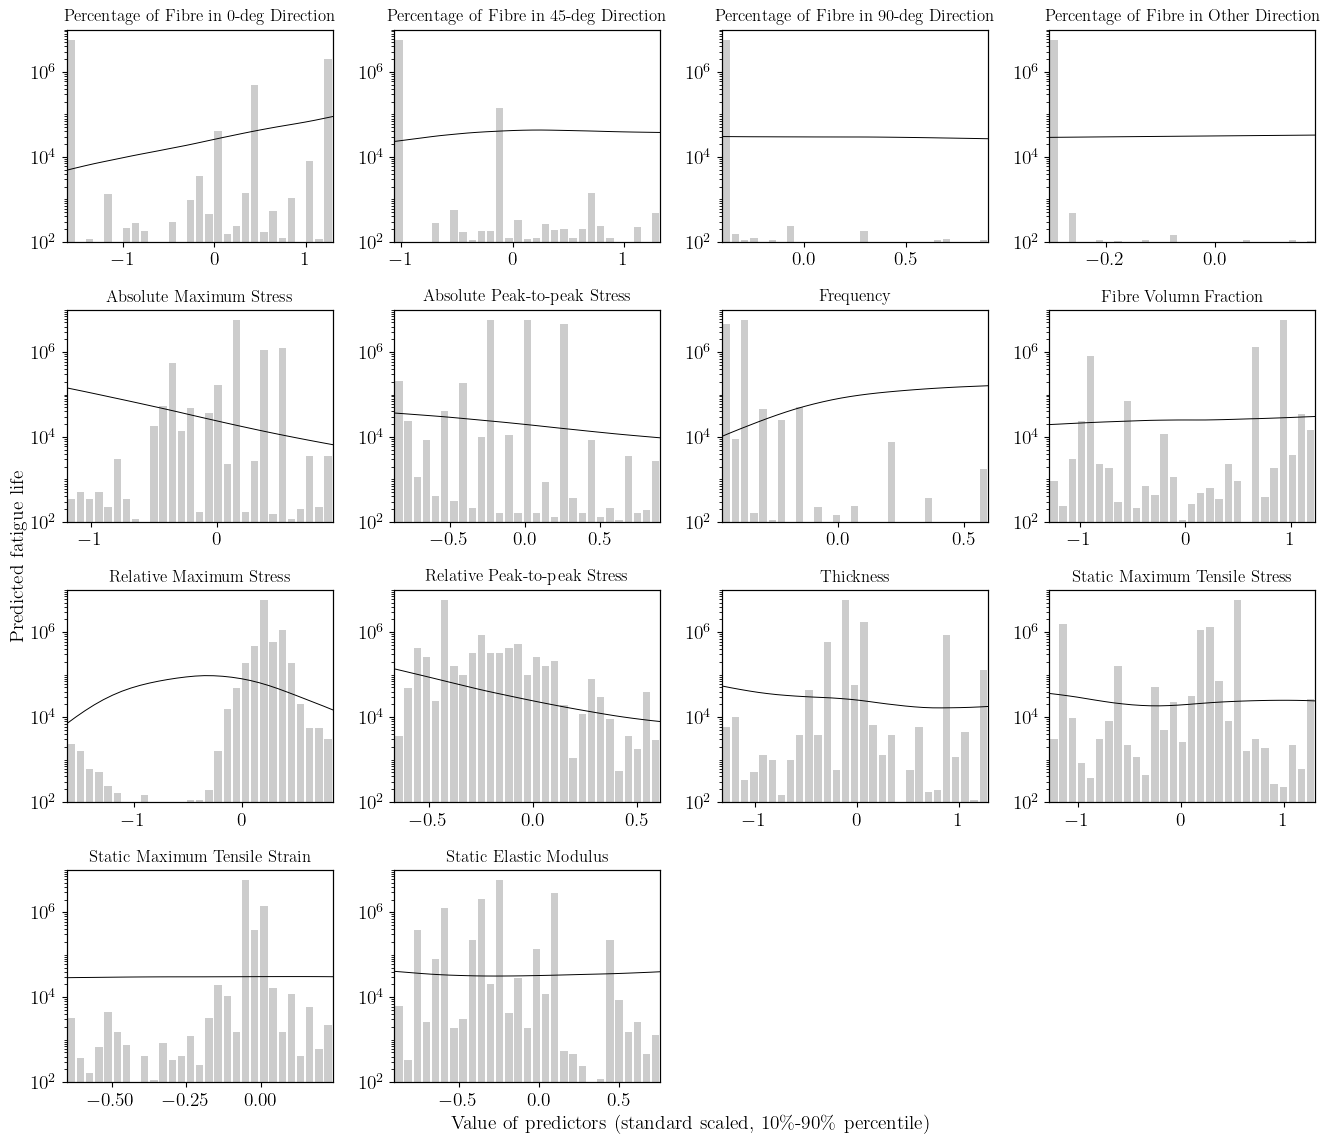

In [ ]:

from utils import calculate_pdp
x_values_list = []
mean_pdp_list = []


for feature_idx in range(len(feature_names)):
    print('Calculate PDP: ',feature_names[feature_idx])
    
    pdp_list = []
    ci_left = []
    ci_right = []
    x_value, model_predictions = calculate_pdp(model,X[train_dataset.indices,:],feature_idx,grid_size=30)
    
    x_values_list.append(x_value)
    mean_pdp_list.append(model_predictions)
    
    
max_col = 4
if len(feature_names)>max_col:
    width = max_col
    if len(feature_names)%max_col == 0:
        height = len(feature_names)//max_col
    else:
        height = len(feature_names)//max_col + 1
    figsize = (14, 3*height)
else:
    figsize = (3*len(feature_names),2.5)
    width = len(feature_names)
    height = 1
print(figsize, width, height)

fig = plt.figure(figsize=figsize)

for idx,focus_feature in enumerate(feature_names):
    ax = plt.subplot(height,width,idx+1)
    # ax.plot(x_values_list[idx], mean_pdp_list[idx], color = clr_map[focus_feature], linewidth = 0.5)
    ax.plot(x_values_list[idx], 10**mean_pdp_list[idx], color = 'k', linewidth = 0.7)

    ax.set_title(focus_feature, {'fontsize': 12})
    ax.set_xlim([0,1])
    ax.set_yscale('log')
    ax.set_ylim([10**2, 10**7])
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[0.1 * x for x in range(10)], numticks=20)
    ax.xaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax2 = ax.twinx()

    chosen_data = X[test_dataset.indices,idx].cpu().detach().numpy()
    ax2.hist(chosen_data,bins=x_values_list[idx],density=True,color=[0,0,0],alpha = .2,rwidth=0.8)
    # sns.rugplot(data=chosen_data, height=0.05, ax=ax2, color='k')
    # ax2.set_ylim([0,1])
    ax2.set_xlim([np.min(x_values_list[idx]), np.max(x_values_list[idx])])
    ax2.set_yticks([])

ax = fig.add_subplot(111,frameon=False)
plt.tick_params(labelcolor='none', which = 'both', top=False,bottom=False, left = False, right=False)
plt.ylabel('Predicted fatigue life')
plt.xlabel('Value of predictors (standard scaled, $10\%$-$90\%$ percentile)')

plt.savefig('../output/partial_dependence.svg')
if is_notebook():
    plt.show()
plt.close()